<a href="https://colab.research.google.com/github/gloriapintado/Breast-Cancer-Prediction/blob/main/Breast_Cancer_Prediction_Baseline_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cancer Prediction by Images Classification

### Overview

“Accurate Diagnosis Health” clinic health located in China just found out that a good amount of their patients who have breast cancer are female patients who come from rural zones. To make it easier for them ‘AD Health’ is putting up small local where screening diagnoses are taken and are being developed on an automated tool for preliminary analysis in breast cancer by allowing quicker identification and referrals of potential cases for better evaluation.


### Data Source

I found a dataset in Kaggle named “Multi Cancer Dataset” which contains many images of different types of cancers such as Acute Lymphoblastic Leukemia, Brain Cancer, Breast Cancer, Cervical Cancer, Kidney Cancer, Lung, Colon Cancer, Lymphoma, and Oral Cancer. However, I will be focusing on Breast Cancer since “AD Health” main goal is to determine by screening diagnosis if they have breast cancer or not.


The data set already has 10,000 images where 5000 of them are diagnosed with malignant and the other 5000 are benign meaning they are noncancerous. Making this a binary classification, target being if they have breast benign or breast malignant.

In [8]:
import os
import cv2
import glob
import random
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from keras.utils import normalize
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input, Activation, Add, Lambda
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Load Dataset

In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
directory_path = '/content/drive/MyDrive/Breast Cancer/'
directories = [d for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d)) and d != '.ipynb_checkpoints']

print(directories)

['breast_benign', 'breast_malignant']


In [10]:
# Define the image directory and size
image_directory = '/content/drive/MyDrive/Breast Cancer/'
SIZE = 200
dataset = []
label = []

In [11]:
breast_malignant_images = os.listdir(image_directory + 'breast_malignant/')
for i, image_name in enumerate(breast_malignant_images):

    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(image_directory + 'breast_malignant/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(1)

breast_benign_images = os.listdir(image_directory + 'breast_benign/')
for i, image_name in enumerate(breast_benign_images):
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(image_directory + 'breast_benign/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(0)

In [12]:
dataset = np.array(dataset)
label = np.array(label)

In [13]:
dataset.shape

(10000, 200, 200, 3)

In [14]:
label.shape

(10000,)

# Exploring Data set

### An image of breast benign

Label for this breast image is:  0


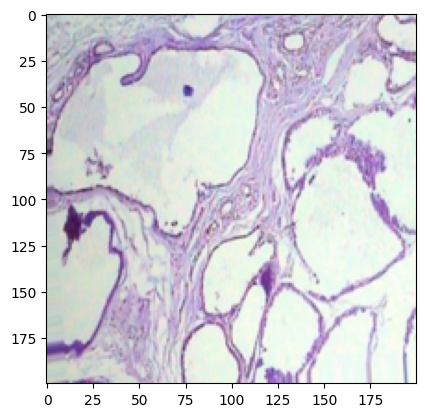

In [34]:
image_number = random.randint(0, len(dataset))
plt.imshow(np.reshape(dataset[image_number], (200, 200, 3)))
print("Label for this breast image is: ", label[image_number])

### An image of breast malignant

Label for this breast image is:  1


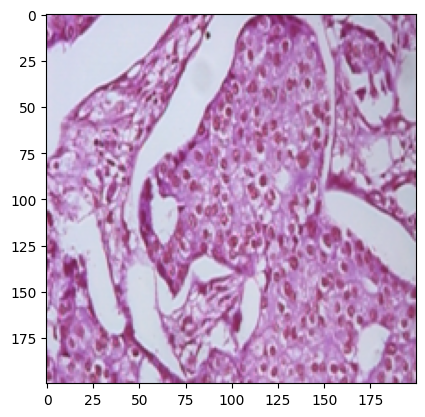

In [36]:
image_number = random.randint(0, len(dataset))
plt.imshow(np.reshape(dataset[image_number], (200, 200, 3)))
print("Label for this breast image is: ", label[image_number])

# Splitting the Data

In [15]:
X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size = 0.20, random_state = 42)

In [16]:
print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))

Training set size: 8000
Testing set size: 2000


In [17]:
print(np.isnan(X_train).sum())
print(np.isnan(X_test).sum())

0
0


In [18]:
print(X_train.shape)
print(X_test.shape)

print(X_train.dtype)
print(X_test.dtype)

(8000, 200, 200, 3)
(2000, 200, 200, 3)
uint8
uint8


# Base Model CNN 1

In [41]:
model = Sequential()

# Normalize the input image data
model.add(Lambda(lambda x: x / 255.0, input_shape=(200, 200, 3)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))

# Fully-connected part of the network
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 99, 99, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 64)        3

In [43]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [44]:
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test), batch_size=100, callbacks=[early_callback])

Epoch 1/15
80/80 [==============================] - 690s 9s/step - loss: 0.5346 - accuracy: 0.7596 - val_loss: 0.3078 - val_accuracy: 0.8780
Epoch 2/15
80/80 [==============================] - 680s 8s/step - loss: 0.3069 - accuracy: 0.8752 - val_loss: 0.2595 - val_accuracy: 0.8970
Epoch 3/15
80/80 [==============================] - 673s 8s/step - loss: 0.2660 - accuracy: 0.8931 - val_loss: 0.2582 - val_accuracy: 0.8970
Epoch 4/15
80/80 [==============================] - 663s 8s/step - loss: 0.2573 - accuracy: 0.8942 - val_loss: 0.2339 - val_accuracy: 0.9050
Epoch 5/15
80/80 [==============================] - 664s 8s/step - loss: 0.2341 - accuracy: 0.9116 - val_loss: 0.2242 - val_accuracy: 0.9070
Epoch 6/15
80/80 [==============================] - 705s 9s/step - loss: 0.2069 - accuracy: 0.9187 - val_loss: 0.3463 - val_accuracy: 0.8540
Epoch 7/15
80/80 [==============================] - 665s 8s/step - loss: 0.2101 - accuracy: 0.9171 - val_loss: 0.2091 - val_accuracy: 0.9195
Epoch 8/15
80

# Accuracy and Loss of Base Model 1

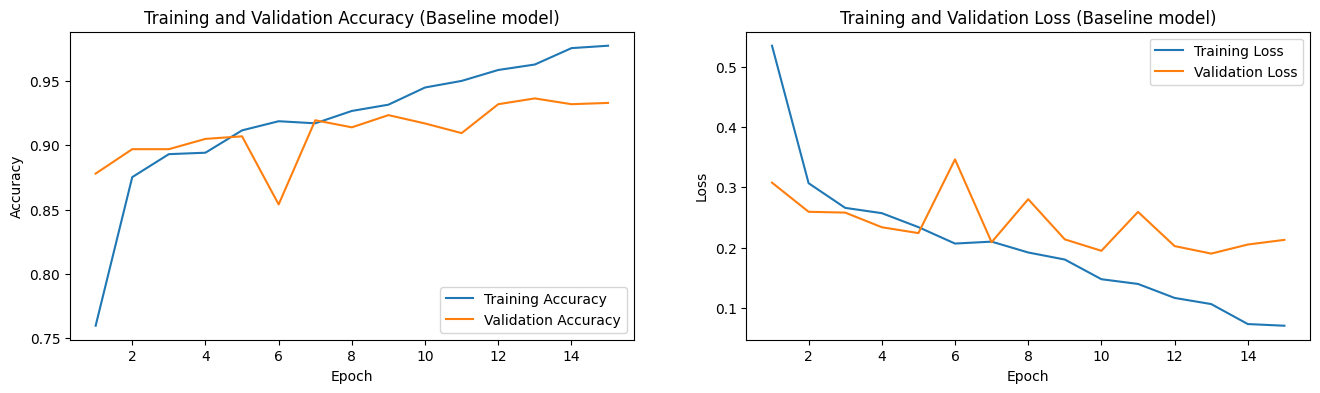

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Baseline model)')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Baseline model)')
plt.show()

In [46]:
class_names = ['breast_benign', 'breast_malignant']

In [47]:
# Make predictions on the test set
predictions = model.predict(X_test)
predicted_classes = np.round(predictions).astype('uint8').flatten()

# Get the true labels for the test set
true_classes = y_test

# classification report
print(classification_report(true_classes, predicted_classes, target_names=class_names, zero_division=0))

63/63 [==============================] - 51s 809ms/step
                  precision    recall  f1-score   support

   breast_benign       0.94      0.92      0.93       988
breast_malignant       0.92      0.95      0.93      1012

        accuracy                           0.93      2000
       macro avg       0.93      0.93      0.93      2000
    weighted avg       0.93      0.93      0.93      2000



# Confusion Matrix for Base Model 1

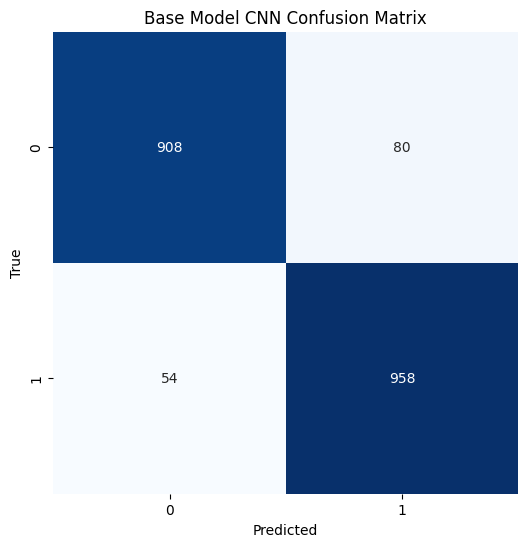

In [48]:
# Confusion matrix
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Base Model CNN Confusion Matrix')
plt.show()

### Saving Model 1

In [61]:
model_save_name = 'model1.h5'
model.save(model_save_name)

model_save_path = model_save_name
drive_path = "/content/gdrive/MyDrive/Breast_Cancer/models/"

!mkdir -p "$drive_path"

!cp $model_save_path $drive_path

# Base Model CNN Model 2

In [19]:
model2 = Sequential()

# Normalize the input image data
model2.add(Lambda(lambda x: x / 255.0, input_shape=(200, 200, 3)))

model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(MaxPooling2D((2, 2)))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D((2, 2)))
model2.add(Conv2D(64, (3, 3), activation='relu'))

# Flatten the output and add dropout and L2 regularization
model2.add(Flatten())
model2.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model2.add(Dropout(0.2))  # 20% dropout rate

model2.add(Dense(1, activation='sigmoid'))

In [20]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 200, 200, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 99, 99, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 46, 46, 64)       

In [21]:
# Compile the model2
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [22]:
history2 = model2.fit(X_train, y_train, epochs=40, validation_data=(X_test, y_test), batch_size=130, callbacks=[early_callback])

Epoch 1/40
62/62 [==============================] - 615s 10s/step - loss: 1.0019 - accuracy: 0.6586 - val_loss: 0.4414 - val_accuracy: 0.8755
Epoch 2/40
62/62 [==============================] - 619s 10s/step - loss: 0.3959 - accuracy: 0.8668 - val_loss: 0.3398 - val_accuracy: 0.8825
Epoch 3/40
62/62 [==============================] - 588s 9s/step - loss: 0.3408 - accuracy: 0.8810 - val_loss: 0.3374 - val_accuracy: 0.8865
Epoch 4/40
62/62 [==============================] - 581s 9s/step - loss: 0.3594 - accuracy: 0.8742 - val_loss: 0.2860 - val_accuracy: 0.8970
Epoch 5/40
62/62 [==============================] - 588s 9s/step - loss: 0.3180 - accuracy: 0.8930 - val_loss: 0.2785 - val_accuracy: 0.9070
Epoch 6/40
62/62 [==============================] - 577s 9s/step - loss: 0.3050 - accuracy: 0.8936 - val_loss: 0.3319 - val_accuracy: 0.8820
Epoch 7/40
62/62 [==============================] - 576s 9s/step - loss: 0.2951 - accuracy: 0.8997 - val_loss: 0.2766 - val_accuracy: 0.9095
Epoch 8/40


# Accuracy and Loss of Base Model 2

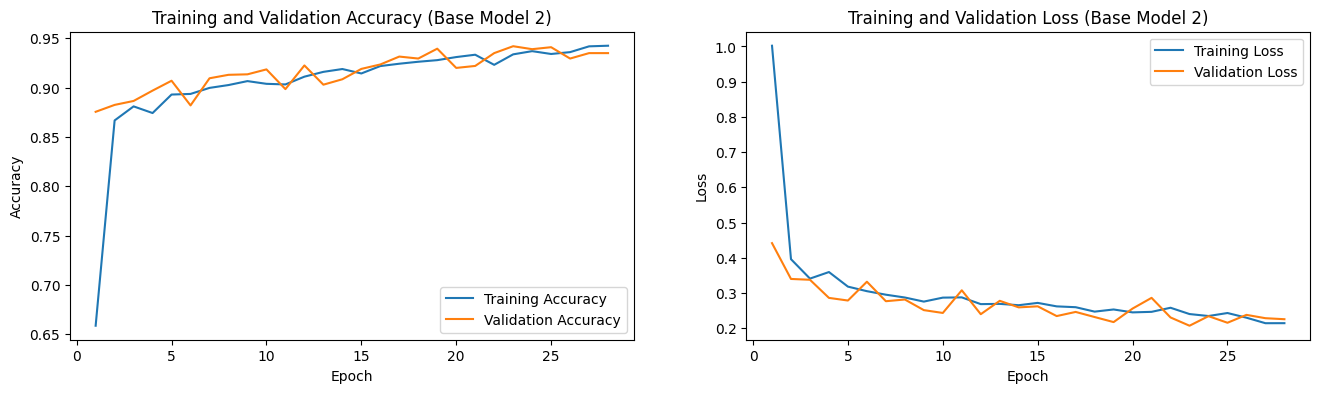

In [23]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Base Model 2)')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Base Model 2)')
plt.show()

In [25]:
class_names = ['breast_benign', 'breast_malignant']

In [26]:
# Make predictions on the test set
predictions = model2.predict(X_test)
predicted_classes = np.round(predictions).astype('uint8').flatten()

# Get the true labels for the test set
true_classes = y_test

# classification report
print(classification_report(true_classes, predicted_classes, target_names=class_names, zero_division=0))

63/63 [==============================] - 51s 797ms/step
                  precision    recall  f1-score   support

   breast_benign       0.98      0.88      0.93       988
breast_malignant       0.90      0.99      0.94      1012

        accuracy                           0.94      2000
       macro avg       0.94      0.93      0.93      2000
    weighted avg       0.94      0.94      0.93      2000



# Confusion Matrix for Base Model 2

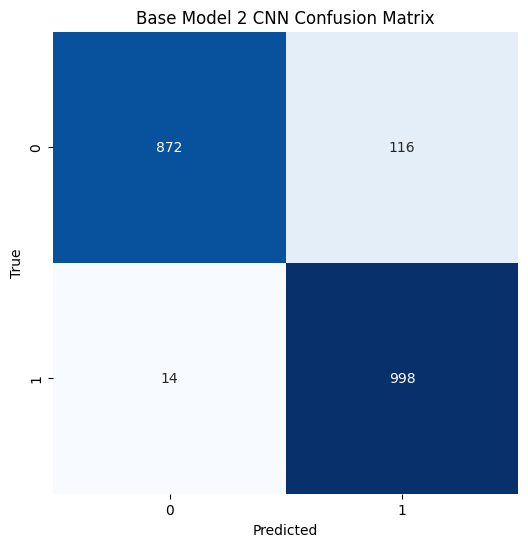

In [27]:
# Confusion matrix
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Base Model 2 CNN Confusion Matrix')
plt.show()

### Saving Base Model 2

In [29]:
model2_save_name = 'model2.h5'
model2.save(model2_save_name)

In [33]:
drive_path = "/content/drive/MyDrive/Breast_Cancer Models/models/"

model2_save_path = os.path.join(drive_path, model2_save_name)
model2.save(model2_save_path)